In [1]:
# import necesarry packages

import numpy as np
import scipy.stats as ss
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## Slice Sampling

### Idea

The single variable slice sampling method replaces the current value,$x_0$, with a new variable $x_1$, found by a three step procesdure as follows:

1. Draw $y\sim\text{Uniform}\left(0,f\left(x_{0}\right)\right)$ to define the horizontal slice $S=\left\{ x:y<f\left(x\right)\right\}$. Note that $x_0$ is always within $S$.
2. Find the interval $I=\left(L, R\right)$ around $x_0$ that contains at least a big part of the slice.
3. Draw the new point $x_1$ from the part of the slice within the interval which is $S\cap I$.

### Finding the appropriate interval
The interval in step 2 $I=\left(L, R\right)$ needs to contain as much of the slice as feasible to allow the new point to differ as much as possible from the previous point. But on the other hand, we don't want it to be much larger than the slice, because it will results to less efrficient sampling. We usually use an estimation $w$ for the scale of $S$ and randomly pick an initial interval of wise $w$ around $x_0$ and then expand it. if it is stepping out it is enouhj to be in the 
if it is doubling it should ne checked.

### sampling from the interval


In [3]:
def w_stepping_out(f, x0, w=1, m=1000):
    """
    stepping out procedure for finding an appropriate interval around
    the current point    
    """
    
    y0 = f(x0)
    y = np.random.uniform(0, y0)
    U = np.random.uniform(0, 1)
    L = x0 - U*w
    R = L + w

    V = np.random.uniform(0, 1)
    J = np.floor(m*V)
    K = (m-1) - J

    while J>0 and y<f(L):
        L = L - w
        J = J - 1
    while K>0 and y<f(R):
        R = R + w
        K = K - 1   
        
    return L, R, y

def w_doubling(f, x0, w=1, p=5):
    """
    doubling procedure for finding an appropriate interval around 
    the current point
    """

    y0 = f(x0)
    y = np.random.uniform(0, y0)
    U = np.random.uniform(0, 1)
    L = x0 - w*U
    R = L + w
    K = p

    while K>0 and (y<f(L) or y<f(R)):
        V = np.random.uniform(0, 1)
        if V<0.5:
            L = L - (R - L)
        else:
            R = R + (R - L)
        K = K - 1
        
    return L, R, y

def accept_doubling(f, x0, x1, y, w, L, R):
    """
    checks if the proposal is acceptable or not
    """
    D = False
    while (R - L) > 1.1*w:
        M = (R + L) / 2
        if (x0<M and x1>=M) or (x0>=M and x1<M):
            D = True
        if x1 < M:
            R = M
        else:
            L = M
        if D and y>=f(L) and y>=f(R):
            return False
    return True  

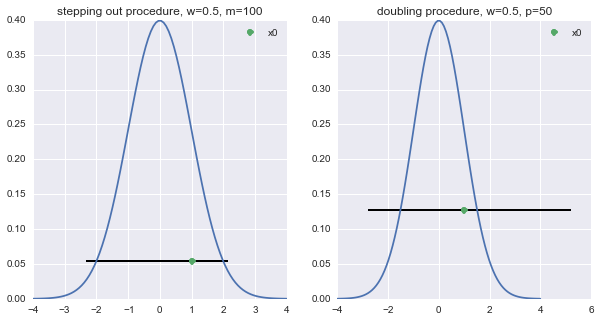

In [9]:
# Plotting the interval I 

f = ss.norm.pdf
x0 = 1
w = 0.5
m = 100
p = 50

L1, R1, y1 = w_stepping_out(f, x0, w, m)
L2, R2, y2 = w_doubling(f, x0, w, p)


X = np.linspace(-4, 4, 100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

### Unimodal densities

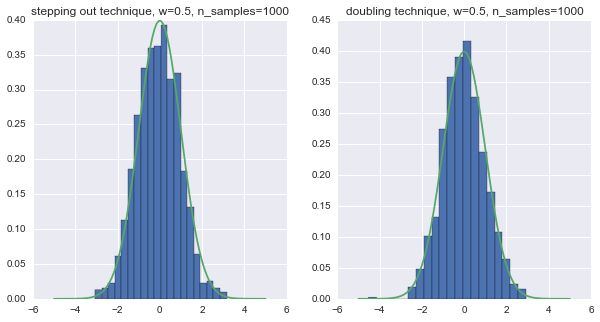

In [4]:
f = ss.norm.pdf
n_samples = 1000

# stepping out procedure
samples1 = []
x0 = 0
w1 = 0.5
m = 50

for i in xrange(n_samples):

    while(True):
        L, R, y = w_stepping_out(f, x0, w1, m)
        x1 = np.random.uniform(L, R)
        
        if f(x1) > y:
            break
        if x1 < x0:
            L = x1
        else:
            R = x1
    samples1.append(x1)
    x0 = x1
    
# doubling procedure    
samples2 = []
x0 = 0
w2 = 0.5
p = 20

for i in xrange(n_samples):

    while(True):
        L, R, y = w_doubling(f, x0, w2, p)
        x1 = np.random.uniform(L, R)
        
        if f(x1) > y and accept_doubling(f, x0, x1, y, w2, L, R):
            break
        if x1 < x0:
            L = x1
        else:
            R = x1
    samples2.append(x1)
    x0 = x1

# visualization
X = np.linspace(-5, 5, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out technique, w={}, n_samples={}".format(w1, n_samples))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}".format(w2, n_samples))

# Multimodal densities

In [5]:
mu1 = 3
mu2 = 10
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)

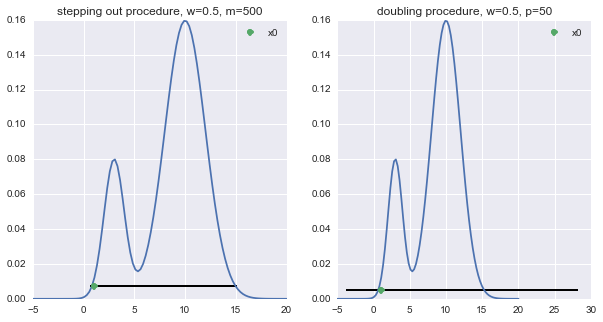

In [6]:
# Plotting the interval I 

x0 = 1
w = 0.5
m = 500
p = 50

L1, R1, y1 = w_stepping_out(f, x0, w, m)
L2, R2, y2 = w_doubling(f, x0, w, p)

X = np.linspace(-5, 20, 100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

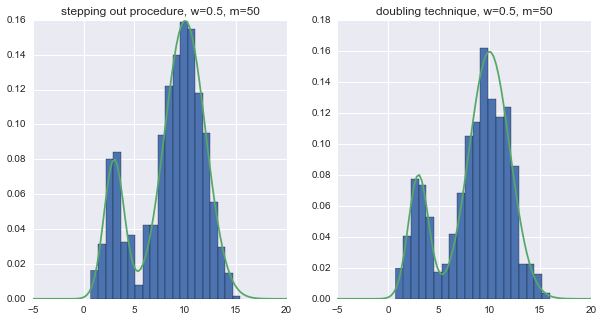

In [7]:
n_samples = 1000

# stepping out technique
samples1 = []
x0 = 0
w = 0.5
m = 50

for i in xrange(n_samples):

    while(True):
        L, R, y = w_stepping_out(f, x0, w, m)
        x1 = np.random.uniform(L, R)
        
        if f(x1) > y:
            break
        if x1 < x0:
            L = x1
        else:
            R = x1
    samples1.append(x1)
    x0 = x1

# doubling technique
samples2 = []
x0 = 0
w = 0.5
p = 20

for i in xrange(n_samples):

    while(True):
        L, R, y = w_doubling(f, x0, w, p)
        x1 = np.random.uniform(L, R)
        
        if f(x1) > y and accept_doubling(f, x0, x1, y, w, L, R):
            break
        if x1 < x0:
            L = x1
        else:
            R = x1
    samples2.append(x1)
    x0 = x1   
    
# visualization
X = np.linspace(-5, 20, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out procedure, w={}, n_samples={}".format(w, n_samples))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}".format(w, n_samples))

What if the two Gaussians are further from each other? As the figures below show, stepping out method will probably not work.

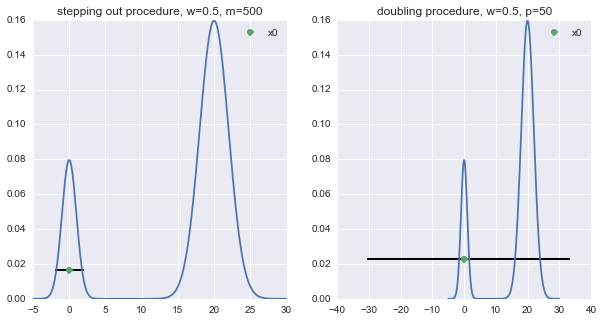

In [31]:
mu1 = 0
mu2 = 20
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)

# Plotting the interval I 
x0 = 0
w = 0.5
m = 50
p = 50

L1, R1, y1 = w_stepping_out(f, x0, w, m)
L2, R2, y2 = w_doubling(f, x0, w, p)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

X = np.linspace(-5, 30, 200)

axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

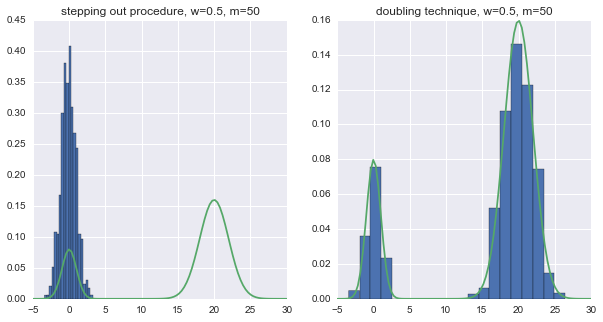

In [33]:
n_samples = 1000

# stepping out technique
samples1 = []
x0 = 0
w = 0.5
m = 50

for i in xrange(n_samples):

    while(True):
        L, R, y = w_stepping_out(f, x0, w, m)
        x1 = np.random.uniform(L, R)
        
        if f(x1) > y:
            break
        if x1 < x0:
            L = x1
        else:
            R = x1
    samples1.append(x1)
    x0 = x1

# doubling technique
samples2 = []
x0 = 0
w = 0.5
p = 20

for i in xrange(n_samples):

    while(True):
        L, R, y = w_doubling(f, x0, w, p)
        x1 = np.random.uniform(L, R)
        
        if f(x1) > y and accept_doubling(f, x0, x1, y, w, L, R):
            break
        if x1 < x0:
            L = x1
        else:
            R = x1
    samples2.append(x1)
    x0 = x1   
    
# visualization
X = np.linspace(-5, 30, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out procedure, w={}, n_samples={}".format(w, n_samples))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}".format(w, n_samples))

Can we get it right by tweaking $w$?

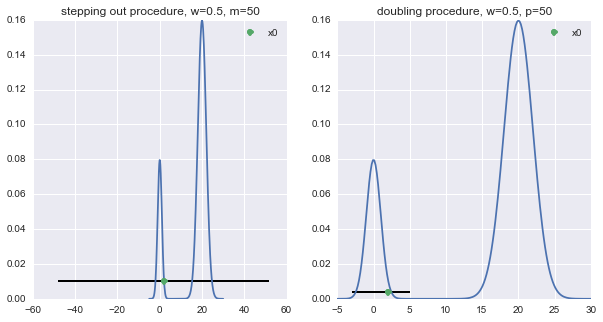

In [39]:
mu1 = 0
mu2 = 20
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)

# Plotting the interval I 
x0 = 2
w1 = 50
w2 = 1.0
m = 50
p = 50

L1, R1, y1 = w_stepping_out(f, x0, w1, m)
L2, R2, y2 = w_doubling(f, x0, w2, p)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

X = np.linspace(-5, 30, 200)

axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

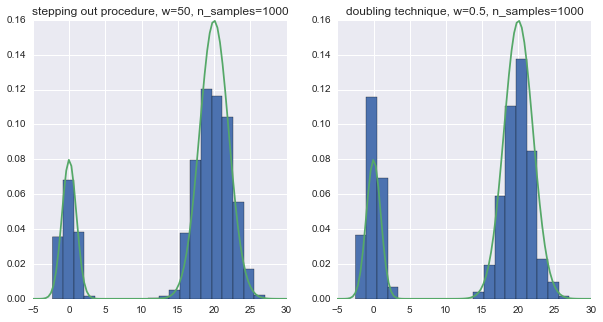

In [41]:
n_samples = 1000

# stepping out technique
samples1 = []
x0 = 0
w1 = 50
m = 50

for i in xrange(n_samples):

    while(True):
        L, R, y = w_stepping_out(f, x0, w1, m)
        x1 = np.random.uniform(L, R)
        
        if f(x1) > y:
            break
        if x1 < x0:
            L = x1
        else:
            R = x1
    samples1.append(x1)
    x0 = x1

# doubling technique
samples2 = []
x0 = 0
w2 = 0.5
p = 20

for i in xrange(n_samples):

    while(True):
        L, R, y = w_doubling(f, x0, w2, p)
        x1 = np.random.uniform(L, R)
        
        if f(x1) > y and accept_doubling(f, x0, x1, y, w2, L, R):
            break
        if x1 < x0:
            L = x1
        else:
            R = x1
    samples2.append(x1)
    x0 = x1   
    
# visualization
X = np.linspace(-5, 30, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out procedure, w={}, n_samples={}".format(w1, n_samples))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}".format(w2, n_samples))

###<span style="color:red">So the question is: How can we choose an appropriate value for w (and also other parameters m, p)?</span>